In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict

In [ ]:
import math

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

pd.set_option('display.max_columns', None)

In [ ]:
output_path = r'/content/drive/MyDrive/rephrasing/CHICAGO/'

## Load Data

In [ ]:

data = r'/content/drive/MyDrive/rephrasing/CHICAGO/chicago_sampled_360.csv'
df = pd.read_csv(data)
#df.sort_values(by='id').head()

NameError: name 'pd' is not defined

In [ ]:
df.head()

,Instance,Continious Score,Class,Number of Words
0,The vast majority of the specialists whom we ...,5.000000,Clear SD,20
1,My vibrations feel like in my spine. I only fe...,4.000000,Clear SD,42
2,Due to this I had a hysterectomy. I react terr...,5.000000,Clear SD,47
3,"I am taking biotin pills, I started washing my...",4.666667,Clear SD,15
4,"About 25 years ago, I skipped the vaccine and ...",4.000000,Clear SD,24


In [ ]:
df.isnull().sum()

,0
Instance,0
Continious Score,0
Class,0
Number of Words,0


In [ ]:
#df['trial_no'] = df.groupby('id').cumcount() + 1

In [ ]:
#df[['id', 'trial_no']].sort_values(by='id')

## Model

In [ ]:
!pip install openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.5/383.5 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.6 MB/s eta 0:00:00


In [ ]:
!pip install tqdm

In [ ]:
import openai, regex, json
from tqdm.auto import tqdm

openai.api_key = "<openai_api_key>"

client = openai

def call_llm(text):

  messages = [
      {
          "role": "user",
          "content": f'''The following is a text collected on a digital platform (like Facebook, patient.info, etc.). Please start by identifying any health-sensitive information about the author included in this text.
Health-sensitive information includes, but is not limited to, details regarding medical conditions, treatments, or personal health experiences.
Propose a sanitized version of the text, in the voice of the reviewer, that maintains its style and overall message while removing sensitive details.


Your output should have the following json format:

{{ "sens_info": Identify each piece of sensitive information included in the review. This field should be left blank if the text is non-sensitive.

"rephrased": Propose a way to sanitize the original text from sensitive information while leaving unrelated words unchanged. This field should be left blank if the text is non-sensitive.

"explanation": Explain why you rephrased different parts of the review and how this makes it less sensitive. This field should be left blank if the text is non-sensitive.

"sens_score": Rate the sensitivity of the original text, on a scale of 1 - 5 as described below

5: The text discloses a specific illness, medication, surgery, or other specific medical variable(s) or event(s).

4: The text discloses specific symptoms but does not further specify an illness, medication, or other diagnosis.


1-3: The text ranges from very low (ambiguous hinting of possible, non-specific medical concerns) to moderate (clear reference to nonspecific medical concerns) self-disclosure.


0: The text does not disclose any health-related information.


"sens_score_reph":  Rate the sensitivity of the rephrased text, on a scale of 1 - 5 as described below

5: The post discloses a specific illness, medication, surgery, or other specific medical variable(s) or event(s).

4: The post discloses specific symptoms but does not further specify an illness, medication, or other diagnosis.


1-3: The post ranges from very low (ambiguous hinting of possible, non-specific medical concerns) to moderate (clear reference to nonspecific medical concerns) self-disclosure.


0: The post does not disclose any health-related information.

}}



the text is,

{text}


important that, the response is a json.

  '''
      }
  ]
  response = client.chat.completions.create(
      model="gpt-4o",
      messages=messages
  )

  # print(f'response {response}')
  # response_body = json.loads(response.get('body').read())

  # text
  # print(f'response_body.get {response.choices[0].message.content}')

  pattern = regex.compile(r'\{(?:[^{}]|(?R))*\}')
  resp = pattern.findall(response.choices[0].message.content)

  try:
      return json.loads(resp[0] if resp else '{}')
  except Exception as e:
      print(f'json decoding failed with error: {e}')
      return {}

def call_llm_with_retry(text):
  retry = 3

  for i in range(retry):
    resp = call_llm(text)
    if resp:
      return resp


In [ ]:
def process_dataframe_subset(df, column_name, start_index, end_index):
    # Select the subset of the DataFrame
    df_subset = df.iloc[start_index:end_index].copy()

    # Apply the function to each value in the column with a progress bar
    tqdm.pandas(desc=f"Processing rows {start_index} to {end_index}")
    df_subset['parsed_json'] = df_subset[column_name].progress_apply(call_llm_with_retry)


    # Get all unique keys from non-empty dictionaries
    all_keys = set()
    for d in tqdm(df_subset['parsed_json'], desc="Collecting keys"):
        all_keys.update(d.keys())

    # Create a new DataFrame, filling in missing values with None
    new_df = pd.DataFrame([{key: d.get(key) for key in all_keys} for d in tqdm(df_subset['parsed_json'], desc="Creating new DataFrame")])

    # Include the original column
    new_df = pd.concat([df_subset[column_name], new_df], axis=1)

    # Optionally, drop columns that are all None
    new_df = new_df.dropna(axis=1, how='all')

    return new_df

In [ ]:
df_sub = process_dataframe_subset(df, "Instance", 0,len(df))

# tqdm.pandas(desc="Processing")
# df['json_output'] = df['original text'].apply(call_llm)

Processing rows 0 to 360:   0%|          | 0/360 [00:00<?, ?it/s]

Creating new DataFrame:   0%|          | 0/360 [00:00<?, ?it/s]

In [ ]:
df_sub.to_csv(f'/content/drive/MyDrive/rephrasing/CHICAGO/processed.csv')

## Data for annotation

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data_annotation = r'/content/drive/MyDrive/rephrasing/CHICAGO/processed.csv'
data_annotation = pd.read_csv(data_annotation)
data_annotation.drop(columns=['Unnamed: 0'], inplace=True)
#add a unique identifier
data_annotation['ID'] = range(0, len(data_annotation))
print(data_annotation.shape)
data_annotation.head()

(590, 7)


,original text,explanation,sens_info,rephrased,sens_score,sens_score_reph,ID
0,my family has been terrified and keeps wanting...,The original text disclosed specific medicatio...,"['beta blocker for my heart', 'xanax for the a...",my family has been concerned and keeps wanting...,5,1,0
1,​If we all focused on 'it could be worse' they...,The term 'depression' is a specific medical co...,depression,"If we all focused on 'it could be worse', ther...",5,3,1
2,"hello all, I read further back evening primros...",The original text disclosed the author's perso...,Information about the author's search for answ...,"hello all, I read further back evening primros...",4,2,2
3,It is very depressing as there is no one able ...,The original text mentions feelings of depress...,It is very depressing as there is no one able ...,It is very frustrating as there is no one able...,3,0,3
4,But don’t worry you are in the right track ba...,Specific details regarding health-sensitive is...,"getting well, stomach probiotics, acidity, dig...",But don’t worry you are on the right track! 😊 ...,4,1,4


Copy the score of the Chicago dataset into the preprocessed one

In [ ]:
df_merged = pd.merge(data_annotation, df[['Instance', 'Class', 'Continious Score']], on='Instance', how='left')

In [ ]:
df_merged = df_merged.drop_duplicates(subset=['ID'], keep='first')
df_merged["Number of Words"] = df_merged["Instance"].apply(lambda n: len(n.split()))

<ipython-input-13-1716637760d2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged["Number of Words"] = df_merged["Instance"].apply(lambda n: len(n.split()))


In [ ]:
df_merged.shape

(360, 10)

In [ ]:
df_merged.isnull().sum()

,0
Instance,0
explanation,90
sens_score,0
sens_info,90
sens_score_reph,0
rephrased,90
ID,0
Class,0
Continious Score,0
Number of Words,0


Sample for the annotation

In [ ]:
grouped = df_merged.groupby('Class')

# Define a function to sample within each group
def sample_equal_rows(group):
    return group.sample(n=min(60, len(group)), replace=True)  # Adjust the number (50) as needed

# Apply the sampling function to each group and concatenate the results
sampled_df = grouped.apply(sample_equal_rows)

# Reset the index of the resulting DataFrame
sampled_df = sampled_df.reset_index(drop=True)

<ipython-input-68-d9ce57f880f6>:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = grouped.apply(sample_equal_rows)


In [ ]:
df_merged.describe()

,sens_score,sens_score_reph,ID,Continious Score,Number of Words
count,360.000000,360.000000,360.000000,360.000000,360.000000
mean,3.247222,1.052778,179.500000,2.453241,34.397222
std,1.993721,1.044947,104.067286,1.891900,29.057823
min,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.750000,0.000000,89.750000,0.000000,18.750000
50%,4.000000,1.000000,179.500000,3.000000,28.000000
75%,5.000000,2.000000,269.250000,4.000000,40.000000
max,5.000000,4.000000,359.000000,5.000000,227.000000


In [ ]:
sampled_df.describe()

,sens_score,sens_score_reph,ID,Continious Score,Number of Words
count,180.000000,180.000000,180.000000,180.000000,180.000000
mean,3.166667,0.977778,175.411111,2.487963,33.261111
std,2.045570,0.991334,103.106702,1.899151,27.938153
min,0.000000,0.000000,2.000000,0.000000,3.000000
25%,0.000000,0.000000,85.250000,0.000000,18.000000
50%,4.000000,1.000000,171.500000,3.000000,27.000000
75%,5.000000,2.000000,259.000000,4.000000,40.000000
max,5.000000,3.000000,354.000000,5.000000,227.000000


In [ ]:
sampled_df.shape

(180, 10)

In [ ]:
#sampled_df.to_csv(output_path + 'annotation_ext_180.csv', index=False)

In [ ]:
sampled_df = pd.read_csv(r'/content/drive/MyDrive/rephrasing/CHICAGO/annotation_ext_180.csv')

In [ ]:
sampled_df.isnull().sum()

,0
Instance,0
explanation,48
sens_score,0
sens_info,48
sens_score_reph,0
rephrased,48
ID,0
Class,0
Continious Score,0
Number of Words,0


Preprocess for Qualtrics

In [ ]:
df_original = sampled_df[['ID', 'Instance', 'sens_score']]
print(df_original.shape)
df_reph = sampled_df[['ID', 'rephrased', 'sens_score_reph']]
print(df_reph.shape)

(180, 3)
(180, 3)


In [ ]:
df_reph.isnull().sum()

,0
ID,0
rephrased,48
sens_score_reph,0


Uniform the columns of the dataset

In [ ]:
df_original.rename(columns={'Instance': 'Text'}, inplace=True)
df_reph.rename(columns={'rephrased': 'Text', 'sens_score_reph' : 'sens_score'}, inplace=True)
df_original.head()

<ipython-input-109-627f2921a7ab>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_original.rename(columns={'Instance': 'Text'}, inplace=True)
<ipython-input-109-627f2921a7ab>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reph.rename(columns={'rephrased': 'Text', 'sens_score_reph' : 'sens_score'}, inplace=True)


,ID,Text,sens_score
0,34,When my ferritin was that low i took ferochel ...,5
1,50,Omg this is how I feel today!!!! I just went t...,4
2,80,i am 52 years old and for years I've felt wort...,3
3,67,"My issue is I had an MRI, that the radiologist...",5
4,22,"hi name_token, i have been off amitriptyline f...",5


In [ ]:

df_reph.head()

,ID,Text,sens_score
0,34,I found that certain supplements helped with h...,1
1,50,Omg this is how I feel today!!!! I just went t...,1
2,80,I've often struggled with feelings of worthles...,2
3,67,"I recently had a scan, and the report suggeste...",2
4,22,"hi name_token, it's been a while since I made ...",2


In [ ]:
df_combined = pd.concat([df_original, df_reph], ignore_index=True)

In [ ]:
df_combined.head()
print(df_combined.shape)

(360, 3)


In [ ]:
df_combined.isnull().sum()

,0
ID,0
Text,48
sens_score,0


The missing texts are just the ones that were not rephrased

In [ ]:
df_combined[['ID', 'Text']].head()

,ID,Text
0,34,When my ferritin was that low i took ferochel ...
1,50,Omg this is how I feel today!!!! I just went t...
2,80,i am 52 years old and for years I've felt wort...
3,67,"My issue is I had an MRI, that the radiologist..."
4,22,"hi name_token, i have been off amitriptyline f..."


In [ ]:
df_combined[['ID', 'Text']].to_csv(output_path + 'human_annotation_360.csv', index=False)

## Preprocessing

Drop if trials happened only 1

In [ ]:
df.columns

Index(['id', 'original text', 'sens_info', 'rephrased', 'explanation',
       'sens_score', 'sens_reph', 'info_score', 'info_reph', 'sens_score_user',
       'sens_reph_user', 'info_score_user', 'info_reph_user', 'detection',
       'detection_2', 'agreement_2', 'sens_score_user_2', 'info_score_user_2',
       'sens_reph_user_2', 'info_reph_user_2', 'agreement', 'trial_no'],
      dtype='object')

In [ ]:
df.columns

Index(['id', 'original text', 'sens_info', 'rephrased', 'explanation',
       'sens_score', 'sens_reph', 'info_score', 'info_reph', 'sens_score_user',
       'sens_reph_user', 'info_score_user', 'info_reph_user', 'detection',
       'detection_2', 'agreement_2', 'sens_score_user_2', 'info_score_user_2',
       'sens_reph_user_2', 'info_reph_user_2', 'agreement', 'trial_no'],
      dtype='object')

In [ ]:
df.sort_values(by='id').head()

KeyError: 'id'

The missing values for sens score means the model hasn't worked properly, it is a FAIL (same for info score)

In [ ]:
df['sens_score'].fillna('FAIL',inplace=True)
df['info_score'].fillna('FAIL',inplace=True)

<ipython-input-21-16653ba5b508>:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'FAIL' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df['sens_score'].fillna('FAIL',inplace=True)
<ipython-input-21-16653ba5b508>:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'FAIL' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df['info_score'].fillna('FAIL',inplace=True)


The missing values for sens reph means there is no rephrasing (same for info reph)

In [ ]:
df['sens_reph'].fillna(-1,inplace=True)
df['info_reph'].fillna(-1,inplace=True)

For the human evaluation, The missing values for sens score user means there is no sensitivity

In [ ]:

df['sens_score_user'].fillna(0,inplace=True)
df['sens_score_user_2'].fillna(0,inplace=True)

KeyError: 'sens_score_user'

For the human evaluation, the missing values for the rephrasing means there is no rephrasing

In [ ]:

df['sens_reph_user'].fillna(-1,inplace=True)
df['sens_reph_user_2'].fillna(-1,inplace=True)

KeyError: 'sens_reph_user'

In [ ]:

df['info_reph_user'].fillna(-1,inplace=True)
df['info_reph_user_2'].fillna(-1,inplace=True)

KeyError: 'info_reph_user'

For the score of the original text, if the value is missing means that the informativeness hasnt been rated by the human so we discard those ones

In [ ]:

df['info_score_user'].fillna(-1,inplace=True)
df['info_score_user_2'].fillna(-1,inplace=True)

In [ ]:
df.isnull().sum()

,0
id,0
original text,0
sens_info,163
rephrased,142
explanation,149
sens_score,0
sens_reph,0
info_score,0
info_reph,0
sens_score_user,0


Eventually, we drop values FAIL and those with -1 for the informativeness

In [ ]:
print(df[df['sens_score'] != 'FAIL'].shape)
print(df[df['info_score_user'] != -1].shape)

(579, 22)
(512, 22)


In [ ]:
df = df[df['sens_score'] != 'FAIL']


In [ ]:
df = df[df['info_score_user'] != -1]

In [ ]:
df.shape

(506, 22)

In [ ]:
df.sort_values(by='id').head()

,id,original text,sens_info,rephrased,explanation,sens_score,sens_reph,info_score,info_reph,sens_score_user,sens_reph_user,info_score_user,info_reph_user,detection,detection_2,agreement_2,sens_score_user_2,info_score_user_2,sens_reph_user_2,info_reph_user_2,agreement,trial_no
35,0,Hi! I literally have the exact problem and hav...,The author reveals their age (19) and shares p...,Hi! I completely relate to this struggle! For ...,The author's age and explicit mention of their...,5.0,1.0,8.0,7.0,7.0,3.0,6.0,6.0,Y,Y,NaN,6.0,7.0,2.0,7.0,NaN,3
34,0,Hi! I literally have the exact problem and hav...,The author mentions suffering from thinning ha...,Hey! It seems I have been dealing with the sam...,"The author's specific age was removed, as well...",7.0,3.0,8.0,8.0,6.0,4.0,6.0,6.0,Y,Y,NaN,7.0,7.0,2.0,7.0,NaN,2
33,0,Hi! I literally have the exact problem and hav...,"The author is 19 years old, experiencing thinn...",Hello! I can completely relate to the struggle...,The text has been rephrased to remove all spec...,6.0,0.0,4.0,3.0,4.0,3.0,7.0,5.0,Y,Y,NaN,7.0,4.0,2.0,4.0,NaN,1
38,1,I had a left hip and L leg EMG done yesterday ...,The author gives specific information about th...,I had some tests and procedures performed rece...,The rephrased text keeps the main themes - the...,7.0,2.0,7.0,5.0,8.0,4.0,6.0,5.0,Y,Y,NaN,6.0,6.0,2.0,6.0,NaN,3
37,1,I had a left hip and L leg EMG done yesterday ...,The author discloses their recent medical test...,I recently visited a clinic for a check-up whi...,I removed specific details about the type of m...,8.0,2.0,9.0,4.0,8.0,3.0,6.0,6.0,Y,Y,NaN,8.0,6.0,2.0,6.0,NaN,2


## Internal consistency of human evaluation

In [ ]:
from scipy.interpolate import make_interp_spline

Uniform columns with the old dataset

In [ ]:
df.rename(columns={
    'id': 'review_id',
    'original text': 'review_text',
                   'sens_score': 'sens_orig',
                   'info_score' : 'info_orig',
                   'sens_score_user': 'sens_or (0-10)',
                   'sens_reph_user' : 'sens_reph (0-10)',
                   'info_score_user': 'info_or (0-10)',
                   'info_reph_user' : 'info_reph (0-10)',
                   'sens_score_user_2': '2_sens_or (0-10)',
                   'info_score_user_2': '2_info_or (0-10)',
                   'sens_reph_user_2': '2_sens_reph (0-10)',
                   'info_reph_user_2' : '2_info_reph (0-10)'

                    }, inplace=True)

review_text = original_text \\
review_id = id \\
sens_orig' = 'sens_score', \\
sens_reph' = 'sens_reph'\
2_sens_or (0-10)' = 'sens_score_user_2' \
sens_reph (0-10)' = 'sens_reph_user' \
sens_or (0-10)' = 'sens_score_user'


In [ ]:
df.shape

(506, 22)


Reduce the dataset to try different shapes

In [ ]:
#df[['id', 'review_text', 'rephrased', 'trial_no']].sort_values(by='id')

## Trial

We need to retireve the disclosure class: Possible, Clear, No. The preprocessing must be improved because if there is only one score, we can't do much about it.


In [ ]:
#df = df_original

In [ ]:
#df = df[df['review_id']==1]

In [ ]:
df.head()

,review_id,review_text,sens_info,rephrased,explanation,sens_orig,sens_reph,info_orig,info_reph,sens_or (0-10),sens_reph (0-10),info_or (0-10),info_reph (0-10),detection,detection_2,agreement_2,2_sens_or (0-10),2_info_or (0-10),2_sens_reph (0-10),2_info_reph (0-10),agreement,trial_no
3,80,It is very depressing as there is no one able ...,The author is expressing feelings of depression.,It is challenging when no one is there to reas...,The author's mention of feeling 'very depressi...,2.0,1.0,6.0,6.0,2.0,2.0,6.0,3.0,N,N,NaN,4.0,6.0,1.0,6.0,N,1
4,81,But don’t worry you are in the right track ba...,NaN,"But don't fret, you're on the right path to im...",NaN,0.0,0.0,6.0,7.0,2.0,2.0,6.0,3.0,N,N,N,0.0,6.0,0.0,6.0,NaN,1
5,87,This medication helps to slow down the bone lo...,The author hints at a personal medical conditi...,This medication is known to slow down bone los...,I removed the first person perspective from th...,2.0,0.0,8.0,8.0,2.0,2.0,6.0,6.0,N,Y,NaN,5.0,6.0,1.0,6.0,N,1
6,93,I see you are concerned about your Dad. As I u...,The author mentions a condition called Alzheim...,I understand your worry about your family memb...,The condition 'Alzheimer's' is replaced with '...,4.0,2.0,7.0,7.0,2.0,2.0,6.0,6.0,N,Y,NaN,5.0,7.0,2.0,7.0,N,1
7,99,It is far more manageable after seeing a docto...,After seeing a doctor/going on potential medic...,It becomes easier to handle with medical advic...,I removed the specific reference to the author...,5.0,0.0,7.0,7.0,0.0,0.0,6.0,6.0,N,Y,NaN,0.0,7.0,0.0,7.0,NaN,1


In [ ]:
########### TRIALS WITH ONE ID
unique_review_ids = df['review_id'].unique()
num_review_ids = len(unique_review_ids)
num_cols = 3  # Number of columns in the grid of subplots should be 6
num_rows = math.ceil(num_review_ids / num_cols)  # Number of rows needed

fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 5*num_rows))

# Iterate over each unique review ID and plot in the subplots
for i, review_id in enumerate(unique_review_ids):
    #print(i, 'this is i')
    #print(review_id, 'this is review')
    row = i // num_cols
    col = i % num_cols

    # Filter data for the current review ID
    df_plt = df[df['review_id'] == review_id][['sens_reph', 'sens_orig', '2_sens_reph (0-10)', '2_sens_or (0-10)', 'trial_no', 'sens_reph (0-10)', 'sens_or (0-10)']]
    df_plt.sort_values(by="trial_no", inplace=True)
    trial_numbers = df_plt['trial_no']#.sort_values()
    sens_reph_scores = df_plt['sens_or (0-10)']
    sens_orig_scores = df_plt['2_sens_or (0-10)']
    model_sens_orig_scores = df_plt['sens_orig']

    # Highlight missing values and values equal to -1
    highlighted_indices_reph = sens_reph_scores[sens_reph_scores == -1].index
    highlighted_indices_orig = sens_orig_scores[sens_orig_scores == -1].index

    # Find missing values
    missing_reph = np.isnan(sens_reph_scores)
    missing_orig = np.isnan(sens_orig_scores)



    # Plot scatter points
    ax = axs[row, col] if num_rows > 1 else axs[col]
    #print(trial_numbers-0.5)
    ax.bar(trial_numbers-0.27, sens_reph_scores, label='Human_1', width=0.27)
    ax.bar(trial_numbers, sens_orig_scores, label='Human_2', width=0.27)
    ax.bar(trial_numbers+0.27, model_sens_orig_scores, label='Model', width=0.27)
    #ax.text(4, 0.5, "X")
    #ax.scatter([], [], color='red', marker='X', label='Missing')

    #ax.scatter(trial_numbers, sens_orig_scores, marker='o', label='Model score')
    #ax.bar(trial_numbers[highlighted_indices_reph]+0.5, sens_reph_scores[highlighted_indices_reph], color='red', label='Unrephrased', width=0.25)
    #ax.bar(trial_numbers[highlighted_indices_orig]+0.5, sens_orig_scores[highlighted_indices_orig], color='red', width=0.25)
    # Plot missing values
    #ax.bar(trial_numbers[missing_reph], sens_reph_scores[missing_reph], color='red')#, label='Missing sens_reph')
    #ax.bar(trial_numbers[missing_orig], sens_orig_scores[missing_orig], color='red')#, label='Missing sens_orig')

    # Adding labels and title
    ax.set_xlabel('Trial Number')
    ax.set_ylabel('Score')
    ax.set_title(f'Text {review_id}')
    ax.legend()
    ax.grid(True)

    # Set limits to ensure all numbers are represented
    ax.set_ylim(-2, 11)
    ax.set_yticks(np.arange(-1, 11, 1))
    ax.set_xlim(0,4)
    ax.set_xticks(np.arange(1, 4, 1))
    #break

fig.suptitle('Sensitivity score between two human evaluators and model on each trial (original text)', y=1)
# Adjust layout and spacing
plt.tight_layout()
plt.subplots_adjust(hspace=0.2, wspace=0.2)  # Customize vertical and horizontal spacing between subplots
#plt.savefig(output_path + 'CHICAGO_comparison_sens_or.png')
plt.show()

In [ ]:
df[df['review_id']==138].head()

,review_id,review_text,sens_info,rephrased,explanation,sens_orig,sens_reph,info_orig,info_reph,sens_or (0-10),sens_reph (0-10),info_or (0-10),info_reph (0-10),detection,detection_2,agreement_2,2_sens_or (0-10),2_info_or (0-10),2_sens_reph (0-10),2_info_reph (0-10),agreement,trial_no
427,138,Im basically taking one day at a time. I guess...,NaN,I'm essentially addressing things one day at a...,NaN,0.0,0.0,5.0,5.0,6.0,3.0,7.0,7.0,Y,Y,NaN,7.0,7.0,1.0,7.0,NaN,2


In [ ]:
df.review_id.value_counts()

,count
review_id,
70,6
74,5
77,5
69,5
68,5
...,...
115,1
108,1
138,1


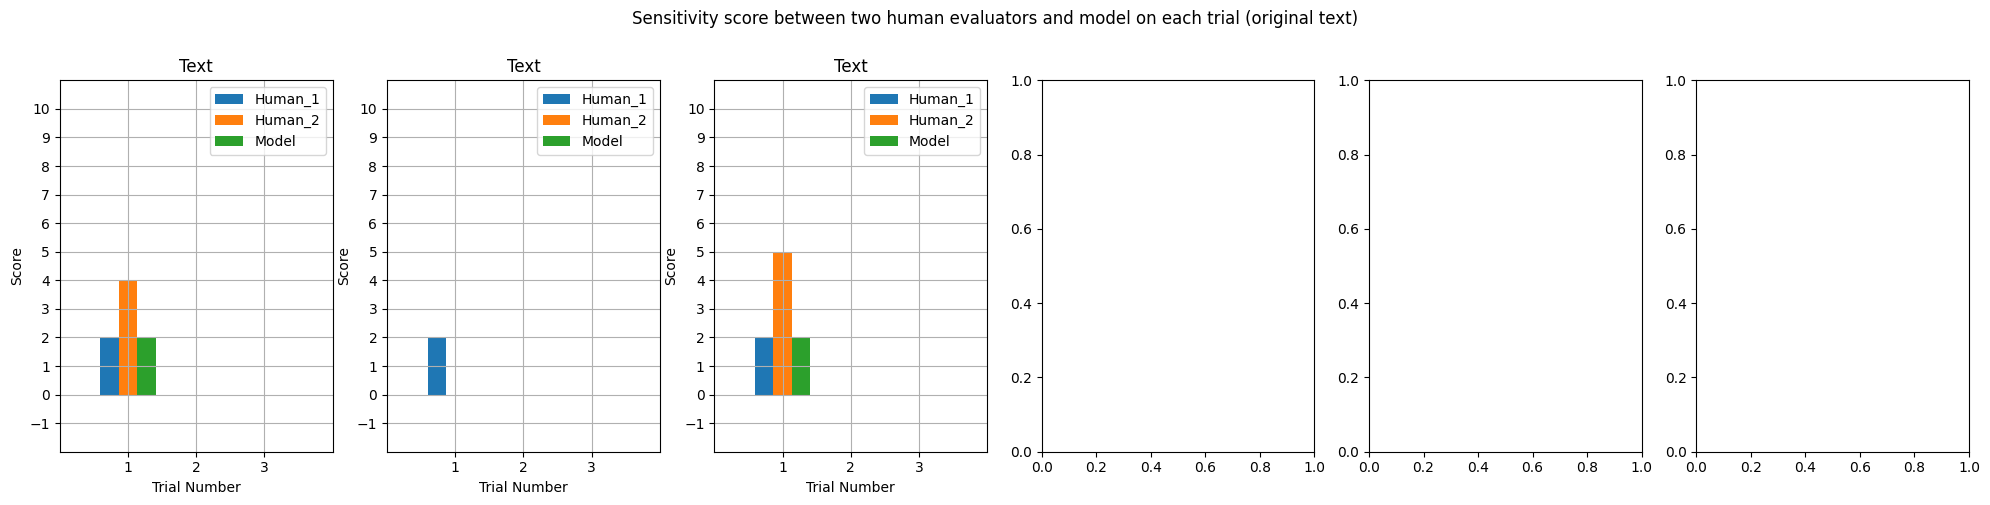

In [ ]:
########### SENS SCORE HHM ORIGINAL
unique_review_ids = df['review_id'].unique()
num_review_ids = len(unique_review_ids)
num_cols = 6  # Number of columns in the grid of subplots
num_rows = math.ceil(num_review_ids / num_cols)  # Number of rows needed

fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 5*num_rows))

# Iterate over each unique review ID and plot in the subplots
for i, review_id in enumerate(unique_review_ids):
    row = i // num_cols
    col = i % num_cols

    # Filter data for the current review ID
    df_plt = df[df['review_id'] == review_id][['sens_reph', 'sens_orig', '2_sens_reph (0-10)', '2_sens_or (0-10)', 'trial_no', 'sens_reph (0-10)', 'sens_or (0-10)']]
    df_plt.sort_values(by="trial_no", inplace=True)
    trial_numbers = df_plt['trial_no']#.sort_values()
    sens_reph_scores = df_plt['sens_or (0-10)']
    sens_orig_scores = df_plt['2_sens_or (0-10)']
    model_sens_orig_scores = df_plt['sens_orig']

    # Highlight missing values and values equal to -1
    highlighted_indices_reph = sens_reph_scores[sens_reph_scores == -1].index
    highlighted_indices_orig = sens_orig_scores[sens_orig_scores == -1].index

    # Find missing values
    missing_reph = np.isnan(sens_reph_scores)
    missing_orig = np.isnan(sens_orig_scores)



    # Plot scatter points
    ax = axs[row, col] if num_rows > 1 else axs[col]
    #print(trial_numbers-0.5)
    ax.bar(trial_numbers-0.27, sens_reph_scores, label='Human_1', width=0.27)
    ax.bar(trial_numbers, sens_orig_scores, label='Human_2', width=0.27)
    ax.bar(trial_numbers+0.27, model_sens_orig_scores, label='Model', width=0.27)
    #ax.text(4, 0.5, "X")
    #ax.scatter([], [], color='red', marker='X', label='Missing')

    #ax.scatter(trial_numbers, sens_orig_scores, marker='o', label='Model score')
    #ax.bar(trial_numbers[highlighted_indices_reph]+0.5, sens_reph_scores[highlighted_indices_reph], color='red', label='Unrephrased', width=0.25)
    #ax.bar(trial_numbers[highlighted_indices_orig]+0.5, sens_orig_scores[highlighted_indices_orig], color='red', width=0.25)
    # Plot missing values
    #ax.bar(trial_numbers[missing_reph], sens_reph_scores[missing_reph], color='red')#, label='Missing sens_reph')
    #ax.bar(trial_numbers[missing_orig], sens_orig_scores[missing_orig], color='red')#, label='Missing sens_orig')

    # Adding labels and title
    ax.set_xlabel('Trial Number')
    ax.set_ylabel('Score')
    ax.set_title(f'Text') #{review_id}')
    ax.legend()
    ax.grid(True)

    # Set limits to ensure all numbers are represented
    ax.set_ylim(-2, 11)
    ax.set_yticks(np.arange(-1, 11, 1))
    ax.set_xlim(0,4)
    ax.set_xticks(np.arange(1, 4, 1))
    #break

fig.suptitle('Sensitivity score between two human evaluators and model on each trial (original text)', y=1)
# Adjust layout and spacing
plt.tight_layout()
plt.subplots_adjust(hspace=0.2, wspace=0.2)  # Customize vertical and horizontal spacing between subplots
plt.savefig(output_path + 'CHICAGO_comparison_sens_or.png')
plt.show()

## P values

In [ ]:
from scipy import stats


df.head()

new = df

# new.groupby("review_id")[["info_orig_avg","info_reph_avg"]].head()
new = df.groupby("review_id")[["info_or (0-10)","info_reph (0-10)"]].mean()
new

# statistic, p_value = stats.ttest_rel(new['info_or (0-10)'], new['info_reph (0-10)'])
# print('t-statistic:', statistic)
# print('p-value:', p_value)
# # df[["info_orig", "info_reph"]].head()

,info_or (0-10),info_reph (0-10)
review_id,,
0,6.333333,5.666667
1,6.666667,5.666667
2,6.000000,6.000000
3,4.000000,1.666667
4,6.000000,4.333333
...,...,...
190,7.666667,7.666667
191,6.666667,6.666667
192,7.000000,7.000000


In [ ]:
df.columns

Index(['review_id', 'review_text', 'sens_info', 'rephrased', 'explanation',
       'sens_orig', 'sens_reph', 'info_orig', 'info_reph', 'sens_or (0-10)',
       'sens_reph (0-10)', 'info_or (0-10)', 'info_reph (0-10)', 'detection',
       'detection_2', 'agreement_2', '2_sens_or (0-10)', '2_info_or (0-10)',
       '2_sens_reph (0-10)', '2_info_reph (0-10)', 'agreement', 'trial_no'],
      dtype='object')

In [ ]:
from scipy import stats


df.head()

new = df

# new.groupby("review_id")[["info_orig_avg","info_reph_avg"]].head()
new = df.groupby("review_id")[["sens_or (0-10)","2_sens_or (0-10)"]].mean().fillna(0)

statistic, p_value = stats.ttest_rel(["sens_or (0-10)"], new["2_sens_or (0-10)"])
print('t-statistic:', statistic)
print('p-value:', p_value)
df[["info_orig", "info_reph"]].head()

ValueError: unequal length arrays

In [ ]:
output_path = r'/content/drive/MyDrive/rephrasing/new_plots/hist/'

In [ ]:
import math

## Boxplot

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


data = r"/content/drive/MyDrive/rephrasing/old_reviews_28x10.csv"
old_df = pd.read_csv(data)
old_df
# select only sensitivity score for original reviews rated by H and M
df_sens = old_df[['review_id', 'info_orig']]
# df_sens_h = df[['review_id', 'mean_sens_or (0-10)']]


In [ ]:
df_sens['sens_reph'].describe()

,sens_reph
count,280.000000
mean,0.189286
std,1.228351
min,-1.000000
25%,-1.000000
50%,0.000000
75%,1.000000
max,3.000000


In [ ]:
df_CL.shape

NameError: name 'df_CL' is not defined

In [ ]:
#add the column to distinguish between H and M and rename other columns
df_sens['evaluator'] = 'M'
# df_sens_h['evaluator'] = 'H'
df_sens.rename(columns={'sens_score' : 'sens'}, inplace=True)
# df_sens_h.rename(columns={'mean_sens_or (0-10)' : 'sens'}, inplace=True)

<ipython-input-20-63128c26eb73>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sens['evaluator'] = 'M'
<ipython-input-20-63128c26eb73>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sens.rename(columns={'sens_score' : 'sens'}, inplace=True)


In [ ]:
df_app =  df_sens

In [ ]:
binary_column = df_app['evaluator']

In [ ]:
df_sens.head()

,review_id,sens_reph,evaluator
0,0,-1,M
1,0,0,M
2,0,0,M
3,0,0,M
4,0,0,M


<ipython-input-6-2f8aca0325cc>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns_plot = sns.boxplot(data=df_sens, x="review_id", y="info_orig", palette=["b"])
<ipython-input-6-2f8aca0325cc>:15: UserWarning: 
The palette list has fewer values (1) than needed (28) and will cycle, which may produce an uninterpretable plot.
  sns_plot = sns.boxplot(data=df_sens, x="review_id", y="info_orig", palette=["b"])


Text(0, 0.5, 'Informativeness Score')

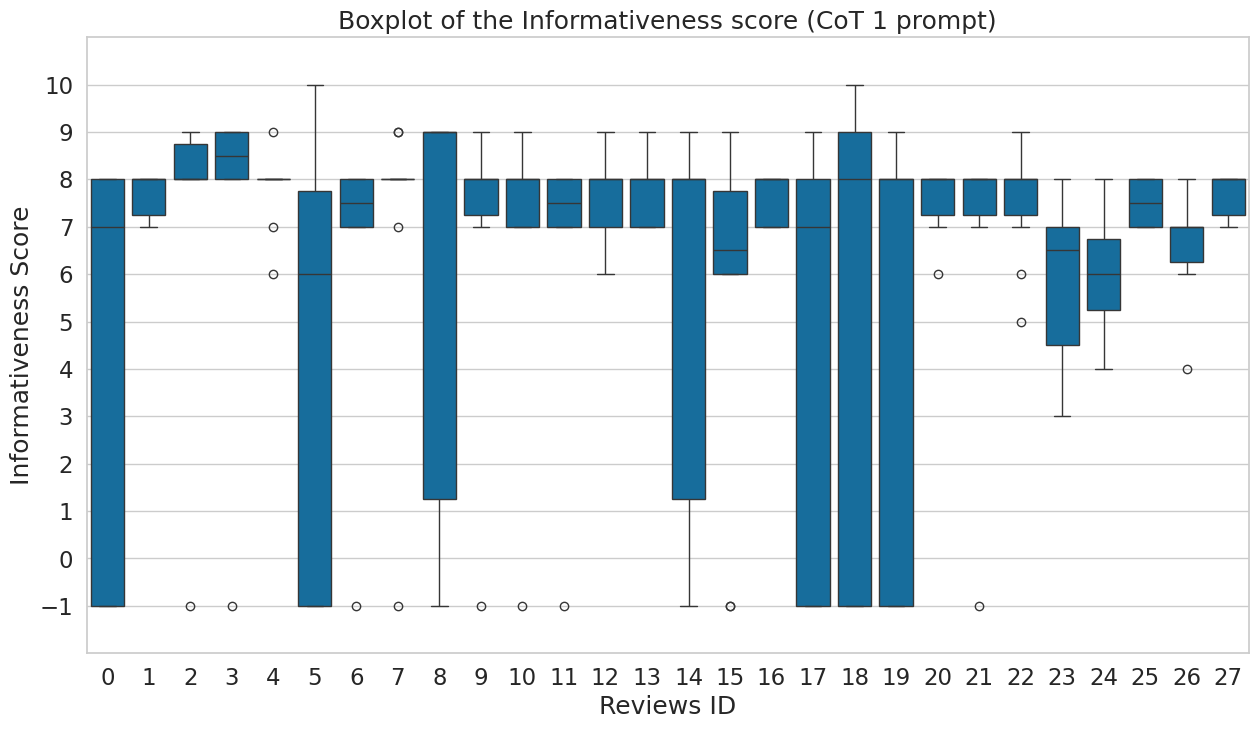

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# data = r"/content/drive/MyDrive/rephrasing/old_reviews_28x10.csv"
# old_df = pd.read_csv(data)

# df_sens_h = df[['review_id', 'mean_sens_or (0-10)']]


fig = plt.figure(figsize=(15, 8))
sns.set_theme(style="whitegrid", palette="colorblind", font_scale=1.5)
plt.title('Boxplot of the Informativeness score (CoT 1 prompt)')
sns_plot = sns.boxplot(data=df_sens, x="review_id", y="info_orig", palette=["b"])
sns_plot.set_xlabel("Reviews ID")
sns_plot.set_ylim(-2, 11)  # Changed from -1 to -1.2 to show some space below -1
sns_plot.set_yticks(range(-1, 11))  # Keeps ticks starting from -1
sns_plot.set_ylabel("Informativeness Score")
#plt.savefig(f"score_stability/sens_score_combined.png")

In [ ]:
sens_or = ['review_id','sens_score']

In [ ]:
sens_or = ['review_id','sens_score', 'mean_sens_or (0-10)']

In [ ]:
df_sens_or_h = df[['review_id', 'mean_sens_or (0-10)']]

In [ ]:
df_app_sens = df_sens_or.append(df_sens_or_h)

In [ ]:
df_app_sens.shape

In [ ]:
df_sens_or_h.head()

In [ ]:
df_sens_or = df[sens_score_or]

In [ ]:
df_sens_or.head()

NameError: name 'df' is not defined

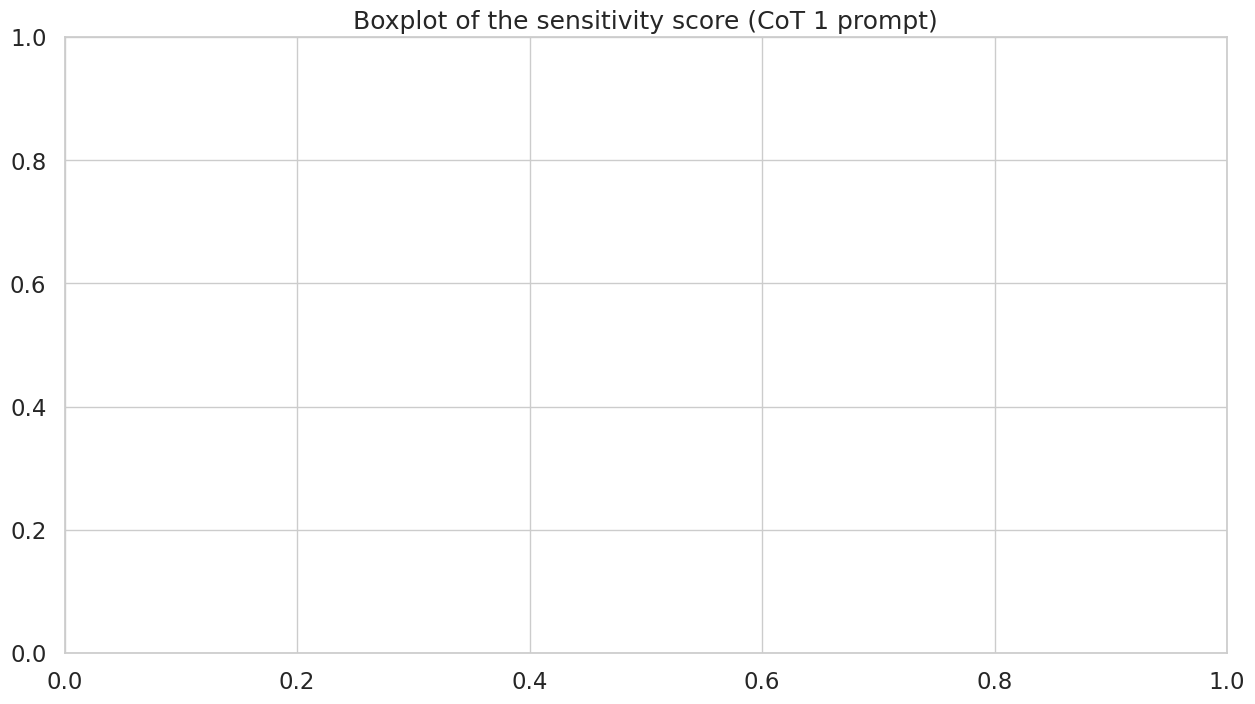

In [ ]:
fig = plt.figure(figsize =(15, 8))
sns.set_theme(style="whitegrid", palette= "colorblind", font_scale=1.5)
plt.title('Boxplot of the sensitivity score (CoT 1 prompt)')
sns_plot = sns.boxplot(data=df, x="review_id", y="sens", hue="review", palette=["b", "y"])
sns_plot.set_xlabel("Reviews ID")
sns_plot.set_ylim(-1, 11)
sns_plot.set_yticks(range(0, 11))
sns_plot.set_ylabel("Sensitivity score of ChatGPT")
plt.savefig(f"score_stability/sens_score_combined.png")

In [ ]:
!pip3 install nltk

In [ ]:
df.head()

,experiment_id,review_id,trial_no,review_text,rephrased_text,explanation,sens_orig_avg,sens_reph_avg,info_orig_avg,info_reph_avg,sens_orig_var,sens_reph_var,info_orig_var,info_reph_var,sens_orig,sens_reph,info_orig,info_reph,failed,detection,sens_or (0-10),sens_reph (0-10),info_or (0-10),info_reph (0-10),comments,2_detection,2_sens_or (0-10),2_sens_reph (0-10),2_info_or (0-10),2_info_reph (0-10),2_comments
0,20,0,1,My husbands ortho doctor suggested him using...,A medical professional suggested the use of Tu...,I removed explicit mention of the user being t...,5.625,0.75,7.25,7.25,2.553571,0.785714,0.5,0.5,3.0,0,8.0,8.0,False,N,8,8.0,8,8.0,"the rephrasing is the same, the detection is a...",N,6,5.0,7,6.0,nearly the same
1,20,0,2,My husbands ortho doctor suggested him using...,A health professional recommended this Turmeri...,I replaced specific reference to the husband's...,5.625,0.75,7.25,7.25,2.553571,0.785714,0.5,0.5,5.0,0,8.0,8.0,False,Y,8,4.0,8,8.0,NaN,Y,7,3.0,7,6.0,NaN
2,20,0,3,My husbands ortho doctor suggested him using...,Turmeric Curcumin was suggested to help with k...,The rephrased review does not directly state t...,5.625,0.75,7.25,7.25,2.553571,0.785714,0.5,0.5,6.0,2,8.0,8.0,False,Y,8,5.0,8,8.0,NaN,Y,6,3.0,6,6.0,NaN
3,20,0,5,My husbands ortho doctor suggested him using...,This Turmeric Curcumin product was recommended...,"In the sanitized version, I've omitted the spe...",5.625,0.75,7.25,7.25,2.553571,0.785714,0.5,0.5,6.0,2,7.0,7.0,False,Y,8,3.0,8,8.0,NaN,Y,6,4.0,6,5.0,NaN
4,20,0,6,My husbands ortho doctor suggested him using...,This Turmeric Curcumin product was suggested b...,"The health status of the reviewer’s husband, h...",5.625,0.75,7.25,7.25,2.553571,0.785714,0.5,0.5,7.0,0,7.0,7.0,False,Y,7,4.0,8,8.0,NaN,Y,6,3.0,6,6.0,NaN


In [ ]:
from nltk.translate import bleu_score as bs
d = data


def get_bleu(r1):
    # print(r1[0])
    try:
      return bs.sentence_bleu([r1[0].split(' ')],r1[1].split(' '))
    except:
      # print(r1[0])
      return 1


# print(get_bleu(("This is a sentence","This is a sentence")))

df["bleu"] = df[["review_text","rephrased_text"]].apply(lambda x: get_bleu(x), axis=1)
df["bleu"].std()

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

0.385613381338645

In [ ]:
def get_bleu(r1):
    # print(r1[0])
    try:
      return bs.sentence_bleu([r1[0].split(' ')],r1[1].split(' '))
    except:
      return 0



df["bleu"] = df[["review_text","rephrased_text"]].apply(lambda x: get_bleu(x), axis=1)

In [ ]:
 !pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=5f53919b1ef45c14b8416b10e052dbda18dcd31f38f20c3395db6722bfe947a5
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [ ]:
from rouge_score import rouge_scorer


def get_rouge1(r1,m):
    scorer = rouge_scorer.RougeScorer([m],use_stemmer=True)
    # print(r1[0])
    try:
      r = scorer.score(r1[0],r1[1])
      # print(r[m])
      return {
          f'{m}_precision': r[m].precision,
          f'{m}_recall': r[m].recall,
          f'{m}_fmeasure': r[m].fmeasure,
      }
    except:
      print("Fail")
      return {
          f'{m}_precision': 0,
          f'{m}_recall': 0,
          f'{m}_fmeasure': 0,
      }


for eval_method in ['rouge1','rouge2','rougeL']:
  resp = df[["review_text","rephrased_text"]].apply(lambda x: get_rouge1(x,eval_method), axis=1, result_type='expand')
  df = pd.concat([df, resp],axis='columns')


Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail


In [ ]:
df.head()

,experiment_id,review_id,trial_no,review_text,rephrased_text,explanation,sens_orig_avg,sens_reph_avg,info_orig_avg,info_reph_avg,sens_orig_var,sens_reph_var,info_orig_var,info_reph_var,sens_orig,sens_reph,info_orig,info_reph,failed,detection,sens_or (0-10),sens_reph (0-10),info_or (0-10),info_reph (0-10),comments,2_detection,2_sens_or (0-10),2_sens_reph (0-10),2_info_or (0-10),2_info_reph (0-10),2_comments,new_col,bleu,rouge1,rouge2,rougeL,rouge1_precision,rouge1_recall,rouge1_fmeasure,rouge2_precision,rouge2_recall,rouge2_fmeasure,rougeL_precision,rougeL_recall,rougeL_fmeasure
0,20,0,1,My husbands ortho doctor suggested him using...,A medical professional suggested the use of Tu...,I removed explicit mention of the user being t...,5.625,0.75,7.25,7.25,2.553571,0.785714,0.5,0.5,3.0,0,8.0,8.0,False,N,8,8.0,8,8.0,"the rephrasing is the same, the detection is a...",N,6,5.0,7,6.0,nearly the same,0,3.582799e-01,0.640000,0.428571,0.620000,0.640000,0.666667,0.653061,0.428571,0.446809,0.437500,0.620000,0.645833,0.632653
1,20,0,2,My husbands ortho doctor suggested him using...,A health professional recommended this Turmeri...,I replaced specific reference to the husband's...,5.625,0.75,7.25,7.25,2.553571,0.785714,0.5,0.5,5.0,0,8.0,8.0,False,Y,8,4.0,8,8.0,NaN,Y,7,3.0,7,6.0,NaN,0,4.747039e-155,0.461538,0.105263,0.358974,0.461538,0.375000,0.413793,0.105263,0.085106,0.094118,0.358974,0.291667,0.321839
2,20,0,3,My husbands ortho doctor suggested him using...,Turmeric Curcumin was suggested to help with k...,The rephrased review does not directly state t...,5.625,0.75,7.25,7.25,2.553571,0.785714,0.5,0.5,6.0,2,8.0,8.0,False,Y,8,5.0,8,8.0,NaN,Y,6,3.0,6,6.0,NaN,0,2.364420e-78,0.560976,0.275000,0.390244,0.560976,0.479167,0.516854,0.275000,0.234043,0.252874,0.390244,0.333333,0.359551
3,20,0,5,My husbands ortho doctor suggested him using...,This Turmeric Curcumin product was recommended...,"In the sanitized version, I've omitted the spe...",5.625,0.75,7.25,7.25,2.553571,0.785714,0.5,0.5,6.0,2,7.0,7.0,False,Y,8,3.0,8,8.0,NaN,Y,6,4.0,6,5.0,NaN,0,3.200304e-155,0.305556,0.057143,0.194444,0.305556,0.229167,0.261905,0.057143,0.042553,0.048780,0.194444,0.145833,0.166667
4,20,0,6,My husbands ortho doctor suggested him using...,This Turmeric Curcumin product was suggested b...,"The health status of the reviewer’s husband, h...",5.625,0.75,7.25,7.25,2.553571,0.785714,0.5,0.5,7.0,0,7.0,7.0,False,Y,7,4.0,8,8.0,NaN,Y,6,3.0,6,6.0,NaN,0,3.563305e-155,0.411765,0.090909,0.235294,0.411765,0.291667,0.341463,0.090909,0.063830,0.075000,0.235294,0.166667,0.195122


In [ ]:
agg = pd.DataFrame(
    {
        "Mean" : [df["rougeL_precision"].mean(),df["rougeL_recall"].mean(),df["rougeL_fmeasure"].mean()],
        "Median" : [df["rougeL_precision"].median(),df["rougeL_recall"].median(),df["rougeL_fmeasure"].median()],
        "St Dev" : [df["rougeL_precision"].std(),df["rougeL_recall"].std(),df["rougeL_fmeasure"].std()],
    },
        index=(["RougeL_precision", "RougeL_recall","RougeL_fmeasure"])

)

In [ ]:
print(agg.style.to_latex())

\begin{tabular}{lrrr}
 & Mean & Median & St Dev \\
RougeL_precision & 0.422417 & 0.412698 & 0.272929 \\
RougeL_recall & 0.361579 & 0.323077 & 0.272239 \\
RougeL_fmeasure & 0.384240 & 0.347826 & 0.271241 \\
\end{tabular}



In [ ]:
print(df["bleu"].mean())
print(df["bleu"].median())
print(df["bleu"].std())

0.17986266233674136
0.06873632942639893
0.2632272662506846


In [ ]:
old_df.column

AttributeError: 'DataFrame' object has no attribute 'column'

In [ ]:


data = r"/content/drive/MyDrive/rephrasing/old_reviews_28x10.csv"
old_df = pd.read_csv(data)
#select only sensitivity score for original reviews rated by H and M
df_sens = old_df[['review_id', 'info_orig']]
df_sens_h = old_df[['review_id', 'sens_score_avg']]

#add the column to distinguish between H and M and rename other columns
# df_sens['evaluator'] = 'M'
# df_sens_h['evaluator'] = 'H'
# df_sens.rename(columns={'sens_score' : 'sens'}, inplace=True)
# df_sens_h.rename(columns={'sens_score_avg' : 'sens'}, inplace=True)
df_app =  df_sens
binary_column = df_app['evaluator']

fig = plt.figure(figsize =(15, 8))
sns.set_theme(style="whitegrid", palette= "colorblind", font_scale=1.5)
plt.title('Boxplot of the sensitivity score annotated with old prompt')
sns_plot = sns.boxplot(data=df_app, x="review_id", y="info_orig", hue="evaluator", palette=["b"])
sns_plot.set_xlabel("Reviews ID")
sns_plot.set_ylim(-1, 11)
sns_plot.set_yticks(range(0, 11))
sns_plot.set_ylabel("Sensitivity score")
#plt.savefig(f"score_stability/sens_score_combined.png")

NameError: name 'pd' is not defined

In [ ]:
old_df.head()

,experiment_id,comment,prompt_id,prompt_template,input_file,review_id,review_text,trial_no,sens_orig_avg,sens_reph_avg,...,info_reph_var,sens_orig,sens_reph,info_orig,info_reph,rephrased_text,failed,explanation,output,price
0,20,Old prompt with 10 tries\n\n,1,I will give you a product review from Amazon a...,/content/drive/MyDrive/rephrasing/all_reviews_...,0,My husbands ortho doctor suggested him using...,0,3.333333,0.5,...,0.166667,-1.0,-1,-1,-1.0,FAIL,True,FAIL,"['{\n""sens_info"": ""My husbands ortho doctor"", ...",0.00000
1,20,Old prompt with 10 tries\n\n,1,I will give you a product review from Amazon a...,/content/drive/MyDrive/rephrasing/all_reviews_...,0,My husbands ortho doctor suggested him using...,1,3.333333,0.5,...,0.166667,3.0,0,8,8.0,The idea of using Turmeric Curcumin was sugges...,False,Mentioning the ortho doctor is potentially sen...,"['{\n""sens_info"": ""My husband\'s ortho doctor ...",0.03123
2,20,Old prompt with 10 tries\n\n,1,I will give you a product review from Amazon a...,/content/drive/MyDrive/rephrasing/all_reviews_...,0,My husbands ortho doctor suggested him using...,2,3.333333,0.5,...,0.166667,2.0,0,8,8.0,An orthopedic specialist recommended Turmeric ...,False,I removed the reference to the husband to anon...,"['{\n""sens_info"": ""My husbands ortho doctor su...",0.03123
3,20,Old prompt with 10 tries\n\n,1,I will give you a product review from Amazon a...,/content/drive/MyDrive/rephrasing/all_reviews_...,0,My husbands ortho doctor suggested him using...,3,3.333333,0.5,...,0.166667,2.0,0,7,7.0,The usage of Turmeric Curcumin was suggested f...,False,The mention of a specific doctor's advice make...,"['{\n""sens_info"": ""My husband\'s ortho doctor ...",0.03123
4,20,Old prompt with 10 tries\n\n,1,I will give you a product review from Amazon a...,/content/drive/MyDrive/rephrasing/all_reviews_...,0,My husbands ortho doctor suggested him using...,4,3.333333,0.5,...,0.166667,3.0,0,8,8.0,This product was suggested for usage to help w...,False,The sensitive information was the specific ref...,"['{\n""sens_info"": ""My husband\'s ortho doctor ...",0.03123


<ipython-input-2-e0e14e7e9b56>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sens['evaluator'] = 'M'
<ipython-input-2-e0e14e7e9b56>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sens_h['evaluator'] = 'H'


Text(0, 0.5, 'Sensitivity score')

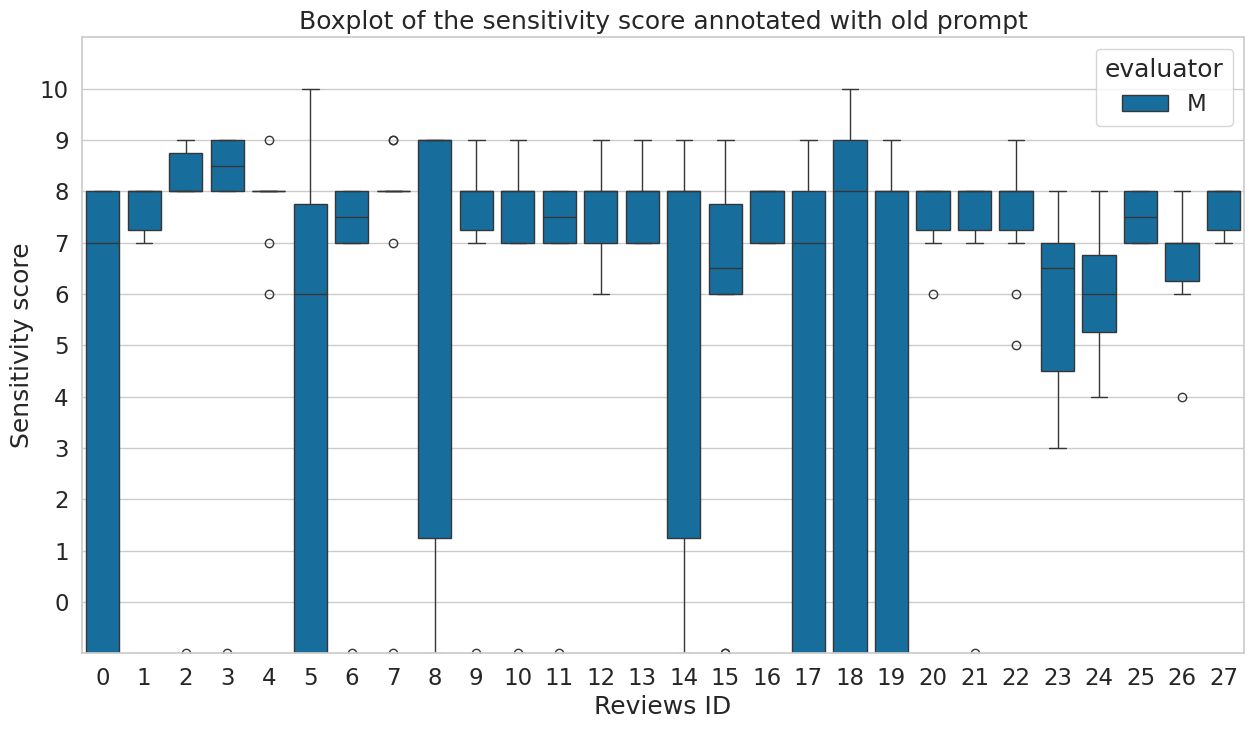

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = r"/content/drive/MyDrive/rephrasing/old_reviews_28x10.csv"
old_df = pd.read_csv(data)
#select only sensitivity score for original reviews rated by H and M
df_sens = old_df[['review_id', 'info_orig']]
df_sens_h = old_df[['review_id', 'sens_reph_avg']]

# #add the column to distinguish between H and M and rename other columns
# df_sens['evaluator'] = 'M'
# df_sens_h['evaluator'] = 'H'
# # df_sens.rename(columns={'sens_score' : 'sens'}, inplace=True)
# # df_sens_h.rename(columns={'sens_score_avg' : 'sens'}, inplace=True)
# df_app =  df_sens
# binary_column = df_app['evaluator']

fig = plt.figure(figsize =(15, 8))
sns.set_theme(style="whitegrid", palette= "colorblind", font_scale=1.5)
plt.title('Boxplot of the sensitivity score annotated with old prompt')
sns_plot = sns.boxplot(data=old_df, x="review_id", y="info_orig", hue="evaluator", palette=["b"])
sns_plot.set_xlabel("Reviews ID")
sns_plot.set_ylim(-1, 11)
sns_plot.set_yticks(range(0, 11))
sns_plot.set_ylabel("Sensitivity score")
#plt.savefig(f"score_stability/sens_score_combined.png")

In [ ]:
old_df.head()

,experiment_id,comment,prompt_id,prompt_template,input_file,review_id,review_text,trial_no,sens_orig_avg,sens_reph_avg,...,info_reph_var,sens_orig,sens_reph,info_orig,info_reph,rephrased_text,failed,explanation,output,price
0,20,Old prompt with 10 tries\n\n,1,I will give you a product review from Amazon a...,/content/drive/MyDrive/rephrasing/all_reviews_...,0,My husbands ortho doctor suggested him using...,0,3.333333,0.5,...,0.166667,-1.0,-1,-1,-1.0,FAIL,True,FAIL,"['{\n""sens_info"": ""My husbands ortho doctor"", ...",0.00000
1,20,Old prompt with 10 tries\n\n,1,I will give you a product review from Amazon a...,/content/drive/MyDrive/rephrasing/all_reviews_...,0,My husbands ortho doctor suggested him using...,1,3.333333,0.5,...,0.166667,3.0,0,8,8.0,The idea of using Turmeric Curcumin was sugges...,False,Mentioning the ortho doctor is potentially sen...,"['{\n""sens_info"": ""My husband\'s ortho doctor ...",0.03123
2,20,Old prompt with 10 tries\n\n,1,I will give you a product review from Amazon a...,/content/drive/MyDrive/rephrasing/all_reviews_...,0,My husbands ortho doctor suggested him using...,2,3.333333,0.5,...,0.166667,2.0,0,8,8.0,An orthopedic specialist recommended Turmeric ...,False,I removed the reference to the husband to anon...,"['{\n""sens_info"": ""My husbands ortho doctor su...",0.03123
3,20,Old prompt with 10 tries\n\n,1,I will give you a product review from Amazon a...,/content/drive/MyDrive/rephrasing/all_reviews_...,0,My husbands ortho doctor suggested him using...,3,3.333333,0.5,...,0.166667,2.0,0,7,7.0,The usage of Turmeric Curcumin was suggested f...,False,The mention of a specific doctor's advice make...,"['{\n""sens_info"": ""My husband\'s ortho doctor ...",0.03123
4,20,Old prompt with 10 tries\n\n,1,I will give you a product review from Amazon a...,/content/drive/MyDrive/rephrasing/all_reviews_...,0,My husbands ortho doctor suggested him using...,4,3.333333,0.5,...,0.166667,3.0,0,8,8.0,This product was suggested for usage to help w...,False,The sensitive information was the specific ref...,"['{\n""sens_info"": ""My husband\'s ortho doctor ...",0.03123


In [ ]:
data_annotation.head()

,original text,explanation,sens_info,rephrased,sens_score,sens_score_reph,ID
0,my family has been terrified and keeps wanting...,The original text disclosed specific medicatio...,"['beta blocker for my heart', 'xanax for the a...",my family has been concerned and keeps wanting...,5,1,0
1,​If we all focused on 'it could be worse' they...,The term 'depression' is a specific medical co...,depression,"If we all focused on 'it could be worse', ther...",5,3,1
2,"hello all, I read further back evening primros...",The original text disclosed the author's perso...,Information about the author's search for answ...,"hello all, I read further back evening primros...",4,2,2
3,It is very depressing as there is no one able ...,The original text mentions feelings of depress...,It is very depressing as there is no one able ...,It is very frustrating as there is no one able...,3,0,3
4,But don’t worry you are in the right track ba...,Specific details regarding health-sensitive is...,"getting well, stomach probiotics, acidity, dig...",But don’t worry you are on the right track! 😊 ...,4,1,4


In [ ]:
!pip install rouge-score nltk

In [ ]:
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu
from nltk.tokenize import word_tokenize
import nltk


def calculate_metrics(df, col1, col2):
    """
    Calculate ROUGE and BLEU scores between two text columns and add results to dataframe.

    Parameters:
    df (pandas.DataFrame): Input dataframe with text columns
    col1 (str): Name of first text column
    col2 (str): Name of second text column

    Returns:
    pandas.DataFrame: Original dataframe with added metric columns
    """
    # Download required NLTK data
    try:
        nltk.download('punkt', quiet=True)
    except:
        pass

    # Initialize ROUGE scorer
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    # Initialize empty lists for scores
    rouge1_scores = []
    rouge2_scores = []
    rougeL_scores = []
    bleu_scores = []

    # Calculate metrics for each row
    for idx, row in df.iterrows():
        if row[col1] == 'nan' or type(row[col2]) != str:
            row[col2] = row[col1]
            continue
        # Calculate ROUGE scores
        rouge_scores = scorer.score(row[col1], row[col2])

        rouge1_scores.append(rouge_scores['rouge1'].fmeasure)
        rouge2_scores.append(rouge_scores['rouge2'].fmeasure)
        rougeL_scores.append(rouge_scores['rougeL'].fmeasure)

        # Prepare texts for BLEU calculation
        reference = [word_tokenize(row[col1].lower())]
        candidate = word_tokenize(row[col2].lower())

        # Calculate BLEU score
        try:
            bleu = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25))
        except:
            bleu = 0.0
        bleu_scores.append(bleu)

    # Add scores to dataframe
    df['rouge1_score'] = rouge1_scores
    df['rouge2_score'] = rouge2_scores
    df['rougeL_score'] = rougeL_scores
    df['bleu_score'] = bleu_scores

    return df

In [ ]:
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.tokenize import word_tokenize
import nltk
import pandas as pd

def calculate_metrics(df, col1, col2):
    """
    Calculate ROUGE and BLEU scores between two text columns and add results to dataframe.
    Uses smoothing for BLEU score calculation to handle cases with few n-gram matches.
    When data is missing or invalid in col2, uses the value from col1.

    Parameters:
    df (pandas.DataFrame): Input dataframe with text columns
    col1 (str): Name of first text column
    col2 (str): Name of second text column

    Returns:
    pandas.DataFrame: Original dataframe with added metric columns
    """
    # Create a copy of the dataframe to avoid modifying the original
    df = df.copy()

    # Download required NLTK data
    try:
        nltk.download('punkt', quiet=True)
    except:
        pass

    # Initialize ROUGE scorer
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    # Initialize smoothing function for BLEU
    smoother = SmoothingFunction().method1

    # Initialize empty lists for scores
    rouge1_scores = []
    rouge2_scores = []
    rougeL_scores = []
    bleu_scores = []

    # Calculate metrics for each row
    for idx, row in df.iterrows():
        # Handle missing or invalid data by setting col2 equal to col1
        if pd.isna(row[col2]) or not isinstance(row[col2], str):
            df.at[idx, col2] = row[col1]

        # Calculate ROUGE scores
        rouge_scores = scorer.score(row[col1], df.at[idx, col2])

        rouge1_scores.append(rouge_scores['rouge1'].fmeasure)
        rouge2_scores.append(rouge_scores['rouge2'].fmeasure)
        rougeL_scores.append(rouge_scores['rougeL'].fmeasure)

        # Prepare texts for BLEU calculation
        reference = [word_tokenize(row[col1].lower())]
        candidate = word_tokenize(df.at[idx, col2].lower())

        # Calculate BLEU score with smoothing
        try:
            # Use lower n-gram order (1-3 instead of 1-4) and smoothing
            bleu = sentence_bleu(
                reference,
                candidate,
                weights=(0.33, 0.33, 0.34, 0),
                smoothing_function=smoother
            )
        except Exception as e:
            print(f"Warning: BLEU score calculation failed for row {idx}: {str(e)}")
            bleu = 0.0
        bleu_scores.append(bleu)

    # Add scores to dataframe
    df['rouge1_score'] = rouge1_scores
    df['rouge2_score'] = rouge2_scores
    df['rougeL_score'] = rougeL_scores
    df['bleu_score'] = bleu_scores

    return df

In [ ]:
scored_df = calculate_metrics(data_annotation, 'original text', 'rephrased')

In [ ]:
scored_df.head()

,original text,explanation,sens_info,rephrased,sens_score,sens_score_reph,ID,rouge1_score,rouge2_score,rougeL_score,bleu_score
0,my family has been terrified and keeps wanting...,The original text disclosed specific medicatio...,"['beta blocker for my heart', 'xanax for the a...",my family has been concerned and keeps wanting...,5,1,0,0.702703,0.611111,0.675676,0.499456
1,​If we all focused on 'it could be worse' they...,The term 'depression' is a specific medical co...,depression,"If we all focused on 'it could be worse', ther...",5,3,1,0.903614,0.829268,0.903614,0.762028
2,"hello all, I read further back evening primros...",The original text disclosed the author's perso...,Information about the author's search for answ...,"hello all, I read further back evening primros...",4,2,2,0.541667,0.446809,0.520833,0.420432
3,It is very depressing as there is no one able ...,The original text mentions feelings of depress...,It is very depressing as there is no one able ...,It is very frustrating as there is no one able...,3,0,3,0.634921,0.426230,0.571429,0.402698
4,But don’t worry you are in the right track ba...,Specific details regarding health-sensitive is...,"getting well, stomach probiotics, acidity, dig...",But don’t worry you are on the right track! 😊 ...,4,1,4,0.580645,0.400000,0.580645,0.350382


In [ ]:
scored_df.to_csv('processed_score.csv')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def plot_metric_statistics(df):
    """
    Create separate plots for mean and standard deviation of ROUGE and BLEU scores.

    Parameters:
    df (pandas.DataFrame): DataFrame containing the metric columns
    """
    # Set style
    plt.style.use('seaborn-v0_8')

    # Calculate statistics
    metrics = ['rouge1_score', 'rouge2_score', 'rougeL_score', 'bleu_score']
    means = [df[metric].mean() for metric in metrics]
    stds = [df[metric].std() for metric in metrics]
    medians = [df[metric].median() for metric in metrics]

    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Nice labels for x-axis
    labels = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'BLEU']
    x = np.arange(len(labels))

    # Plot means
    bars1 = ax1.bar(x, means, alpha=0.8)
    ax1.set_ylabel('Mean Score')
    ax1.set_title('Mean Scores by Metric')
    ax1.set_xticks(x)
    ax1.set_xticklabels(labels)

    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom')

    # Plot standard deviations
    bars2 = ax2.bar(x, stds, alpha=0.8)
    ax2.set_ylabel('Standard Deviation')
    ax2.set_title('Standard Deviation by Metric')
    ax2.set_xticks(x)
    ax2.set_xticklabels(labels)

    # Add value labels on bars
    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom')

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

    # Print numerical summary
    print("\nNumerical Summary:")
    print("-----------------")
    for metric, mean, median, std in zip(labels, means, medians, stds):
        print(f"{metric}:")
        print(f"  Mean:   {mean:.3f}")
        print(f"  Median: {median:.3f}")
        print(f"  Std:    {std:.3f}")
        print()

# To use the function:
# plot_metric_statistics(your_dataframe)

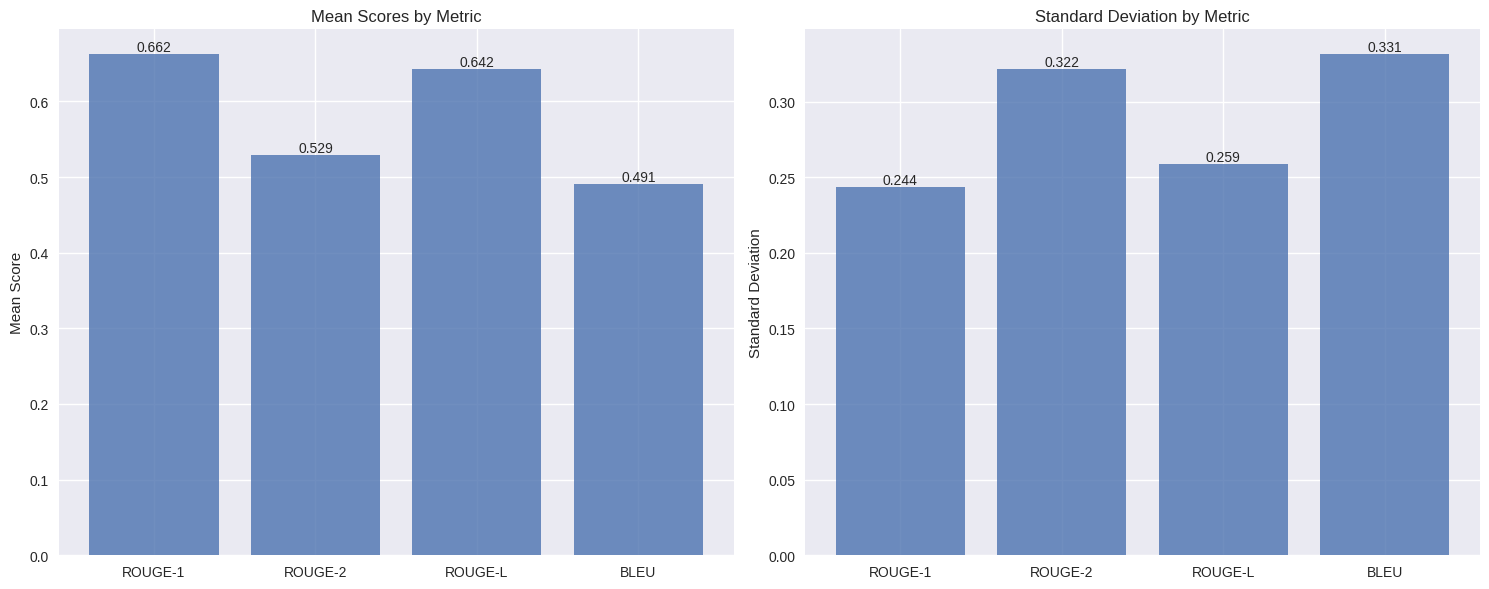


Numerical Summary:
-----------------
ROUGE-1:
  Mean:   0.662
  Median: 0.651
  Std:    0.244

ROUGE-2:
  Mean:   0.529
  Median: 0.500
  Std:    0.322

ROUGE-L:
  Mean:   0.642
  Median: 0.637
  Std:    0.259

BLEU:
  Mean:   0.491
  Median: 0.435
  Std:    0.331



In [ ]:
plot_metric_statistics(scored_df)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def plot_metric_distributions(df):
    """
    Create violin plots showing the distribution of each metric.
    """
    # Melt the dataframe to get metrics in long format
    metrics = ['rouge1_score', 'rouge2_score', 'rougeL_score', 'bleu_score']
    df_melted = df[metrics].melt()

    # Create violin plot
    plt.figure(figsize=(12, 6))
    sns.violinplot(data=df_melted, x='variable', y='value')
    plt.title('Distribution of Metric Scores')
    plt.xticks(range(4), ['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'BLEU'])
    plt.xlabel('Metric')
    plt.ylabel('Score')
    plt.show()

def plot_metric_boxplots(df):
    """
    Create box plots with individual points showing the distribution of each metric.
    Uses a white background with a grid for better readability.
    """
    metrics = ['rouge1_score', 'rouge2_score', 'rougeL_score', 'bleu_score']
    df_melted = df[metrics].melt()

    # Set the style to white background
    plt.style.use('seaborn-v0_8-whitegrid')

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(12, 6))

    # Set background color
    ax.set_facecolor('white')
    fig.patch.set_facecolor('white')

    # Create the plots
    sns.boxplot(data=df_melted, x='variable', y='value', showfliers=True, ax=ax)
    sns.swarmplot(data=df_melted, x='variable', y='value', color='red', alpha=0.5, size=4, ax=ax)

    # Customize the plot
    plt.title('Boxplot of the F1 scores', pad=15)
    plt.xticks(range(4), ['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'BLEU'])
    plt.xlabel('Metric')
    plt.ylabel('Score')

    # Add grid for better readability
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

def plot_metric_heatmap(df):
    """
    Create a correlation heatmap between metrics.
    """
    metrics = ['rouge1_score', 'rouge2_score', 'rougeL_score', 'bleu_score']
    corr_matrix = df[metrics].corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix,
                annot=True,
                cmap='coolwarm',
                center=0,
                vmin=-1,
                vmax=1,
                square=True)
    plt.title('Correlation Heatmap between Metrics')
    tick_labels = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'BLEU']
    plt.xticks(np.arange(4) + 0.5, tick_labels, rotation=45)
    plt.yticks(np.arange(4) + 0.5, tick_labels, rotation=0)
    plt.tight_layout()
    plt.show()

def plot_metric_density(df):
    """
    Create kernel density estimation plots for all metrics.
    """
    plt.figure(figsize=(12, 6))
    metrics = ['rouge1_score', 'rouge2_score', 'rougeL_score', 'bleu_score']
    for metric in metrics:
        sns.kdeplot(data=df[metric], label=metric)
    plt.title('Density Distribution of Metrics')
    plt.xlabel('Score')
    plt.ylabel('Density')
    plt.legend(labels=['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'BLEU'])
    plt.show()

def plot_metric_scatter_matrix(df):
    """
    Create a scatter plot matrix showing relationships between metrics.
    """
    metrics = ['rouge1_score', 'rouge2_score', 'rougeL_score', 'bleu_score']
    labels = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'BLEU']

    # Create scatter plot matrix
    fig, axes = plt.subplots(4, 4, figsize=(15, 15))
    fig.suptitle('Scatter Plot Matrix of Metrics', y=1.02, size=16)

    for i, metric1 in enumerate(metrics):
        for j, metric2 in enumerate(metrics):
            ax = axes[i, j]
            if i != j:
                # Scatter plot with regression line
                sns.regplot(data=df, x=metric2, y=metric1, ax=ax,
                          scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
            else:
                # Histogram on diagonal
                sns.histplot(data=df, x=metric1, ax=ax, bins=20)

            if i == len(metrics)-1:
                ax.set_xlabel(labels[j])
            if j == 0:
                ax.set_ylabel(labels[i])

    plt.tight_layout()
    plt.show()

def plot_metric_time_series(df):
    """
    Create a time series plot of all metrics.
    """
    plt.figure(figsize=(15, 6))
    metrics = ['rouge1_score', 'rouge2_score', 'rougeL_score', 'bleu_score']

    for metric in metrics:
        plt.plot(df.index, df[metric], label=metric, alpha=0.7, marker='o', markersize=4)

    plt.title('Metric Scores Over Samples')
    plt.xlabel('Sample Index')
    plt.ylabel('Score')
    plt.legend(labels=['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'BLEU'])
    plt.grid(True, alpha=0.3)
    plt.show()

# Function to create all visualizations
def create_all_visualizations(df):
    """
    Create all visualizations for the metrics data.

    Parameters:
    df (pandas.DataFrame): DataFrame containing the metric columns
    """
    plot_metric_distributions(df)
    plot_metric_boxplots(df)
    plot_metric_heatmap(df)
    plot_metric_density(df)
    plot_metric_scatter_matrix(df)
    plot_metric_time_series(df)

# Usage example:
# create_all_visualizations(your_dataframe)

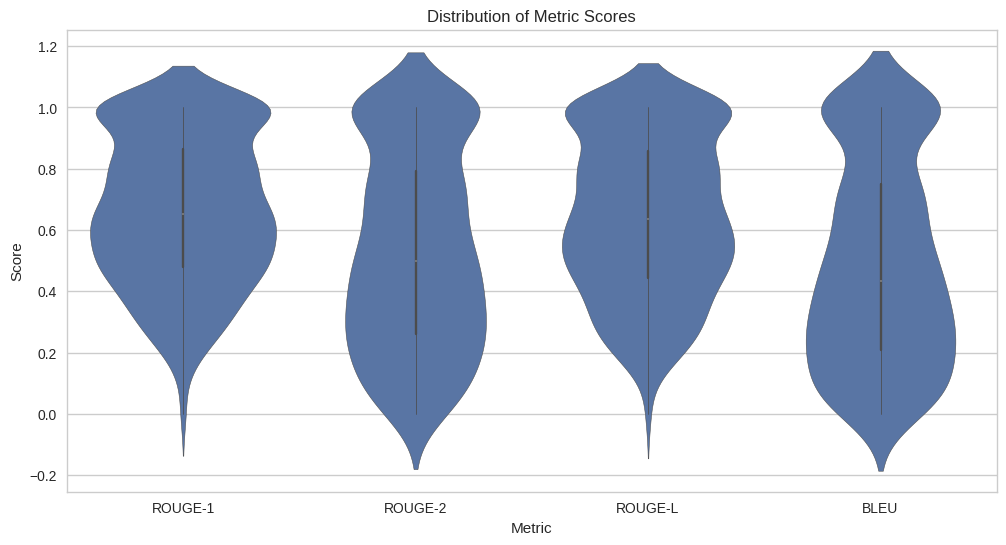

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3399: UserWarning: 14.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3399: UserWarning: 14.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3399: UserWarning: 13.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3399: UserWarning: 12.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


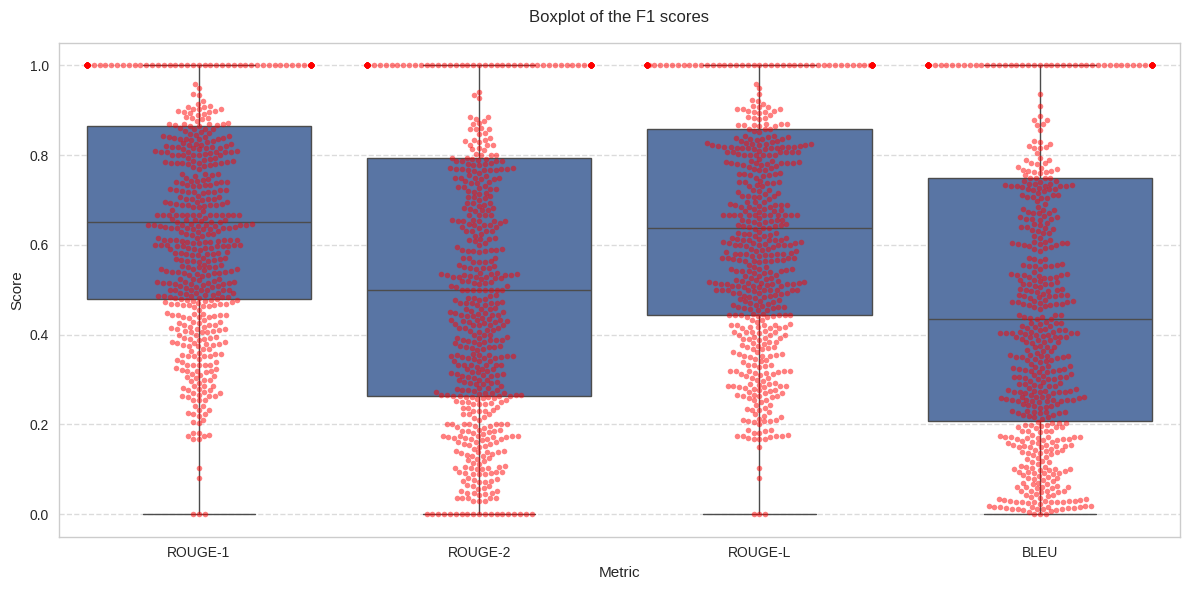

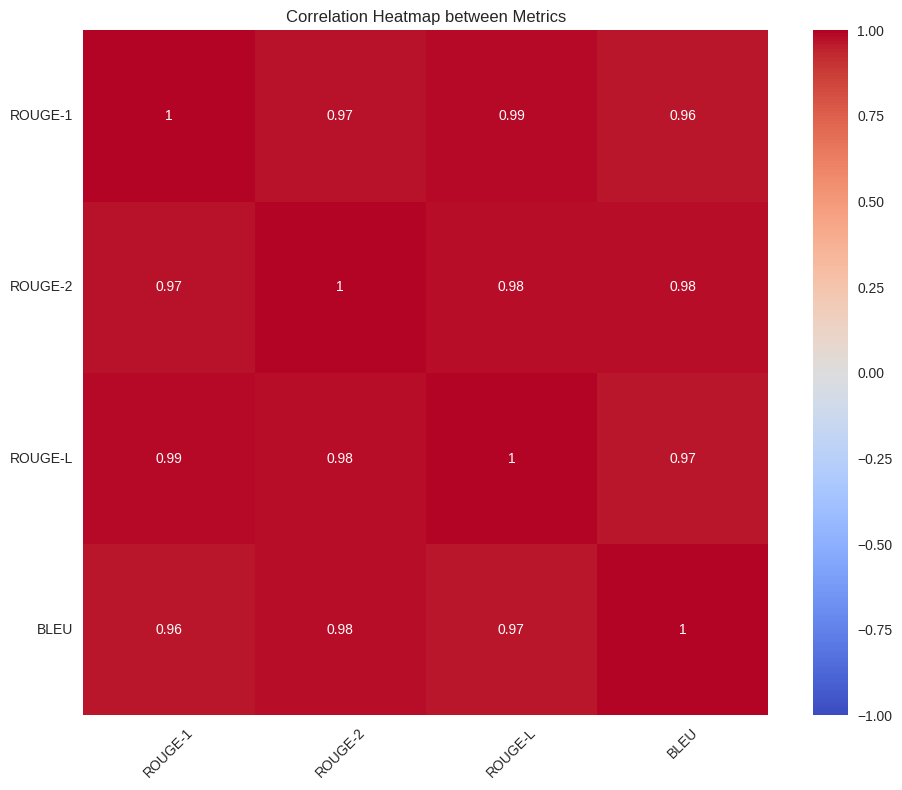

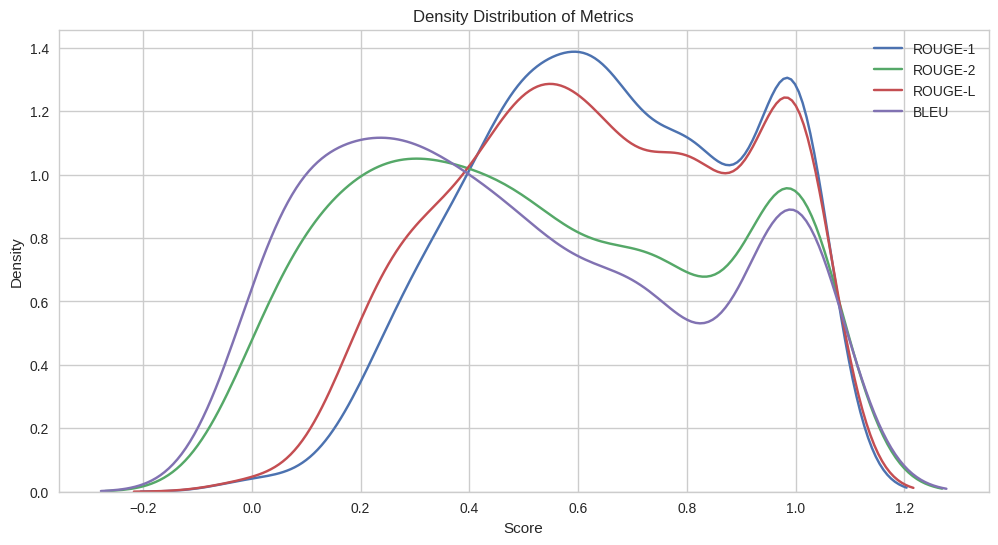

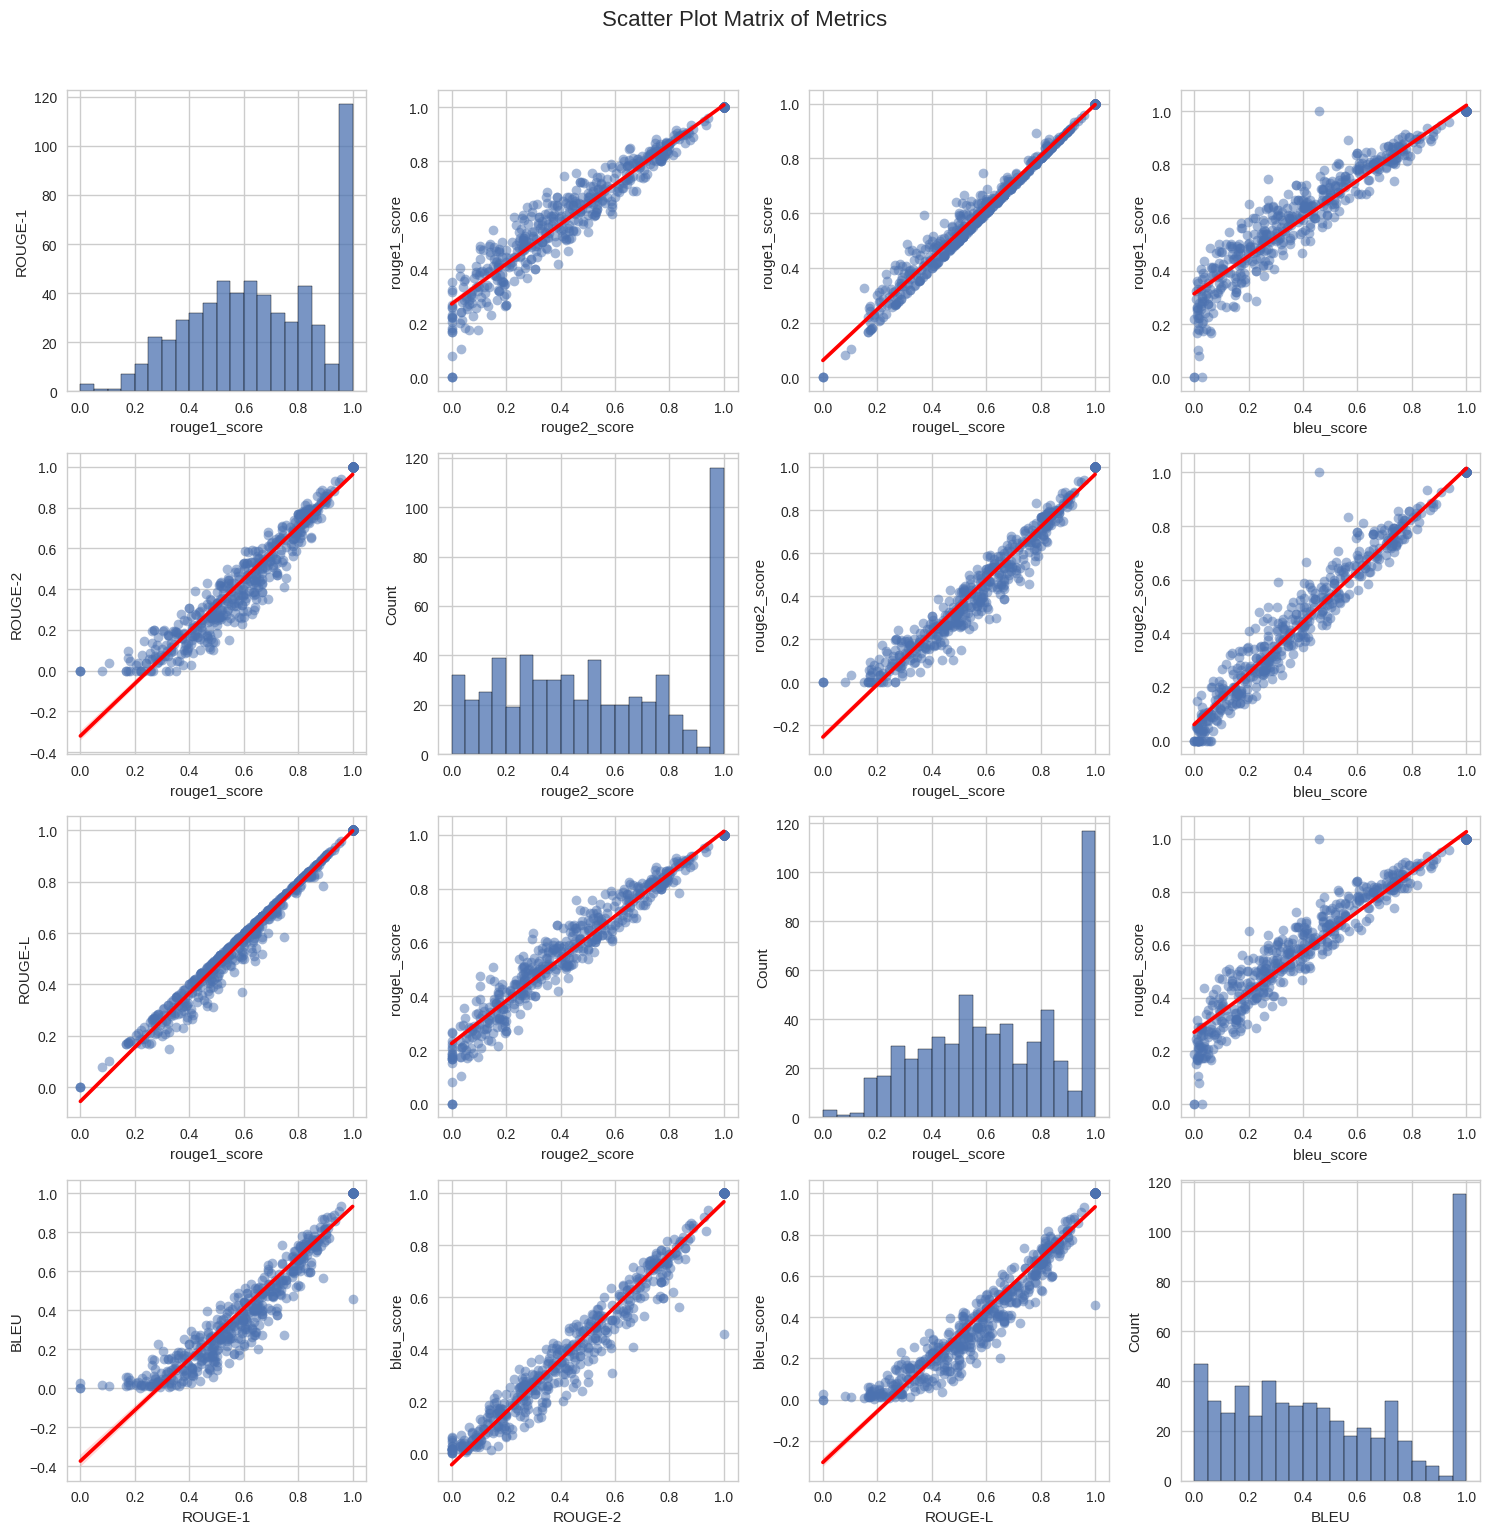

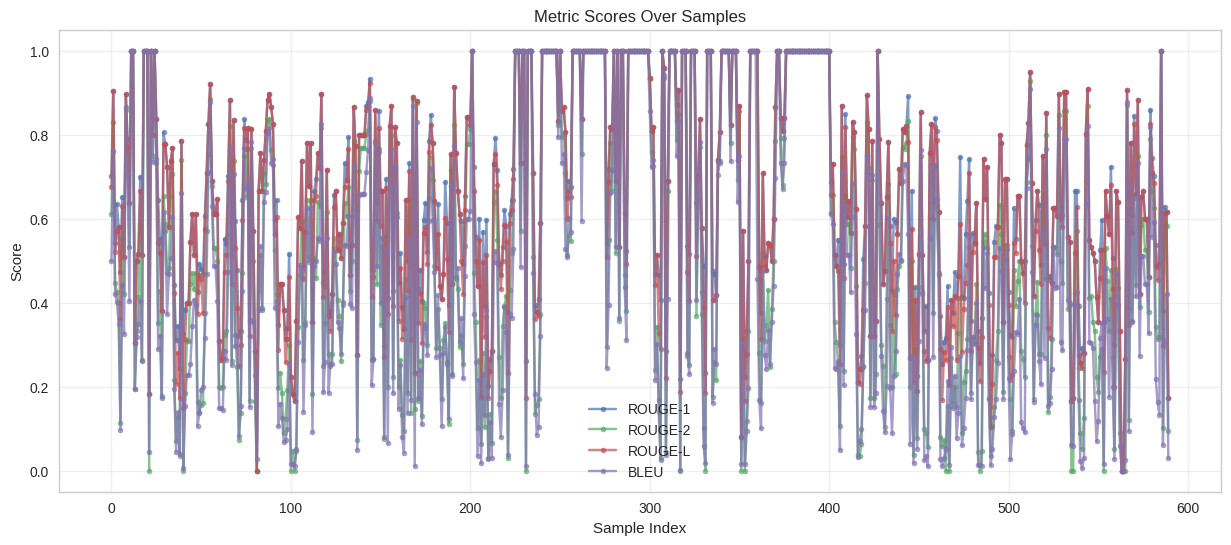

In [ ]:
create_all_visualizations(scored_df)